# Model Distillation drift detector on CIFAR-10

### Method

[Model distillation](https://arxiv.org/abs/1503.02531) is a technique that is used to transfer knowledge from a large network to a smaller network. Typically, it consists of training a second model with a simplified architecture on soft targets (the output distributions or the logits) obtained from the original model. 

Here, we apply model distillation to obtain harmfulness scores, by comparing the output distributions of the original model with the output distributions 
of the distilled model, in order to detect adversarial data, malicious data drift or data corruption.
We use the following definition of harmful and harmless data points:

* Harmful data points are defined as inputs for which the model's predictions on the uncorrupted data are correct while the model's predictions on the corrupted data are wrong.

* Harmless data points are defined as inputs for which the model's predictions on the uncorrupted data are correct and the model's predictions on the corrupted data remain correct.

Analogously to the [adversarial AE detector](https://arxiv.org/abs/2002.09364), which is also part of the library, the model distillation detector picks up drift that reduces the performance of the classification model. 

Moreover, in this example a drift detector that applies two-sample [Kolmogorov-Smirnov](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) (K-S) tests to the scores is employed. The p-values obtained are used to assess the harmfulness of the data. 

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from alibi_detect.cd import KSDrift
from alibi_detect.ad import ModelDistillation

from alibi_detect.models.tensorflow import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.tensorflow import predict_batch
from alibi_detect.saving import save_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

### Load data

Original CIFAR-10 data:

In [5]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_train = scale_by_instance(X_train)
y_train = y_train.astype('int64').reshape(-1,)
X_test = X_test.astype('float32') / 255
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [6]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [7]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the corrupted data by corruption type:

In [8]:
X_c = []
n_corr = len(corruption)
n_test = X_test.shape[0]
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

We can visualise the same instance for each corruption type:

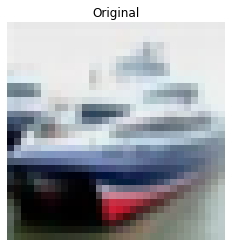

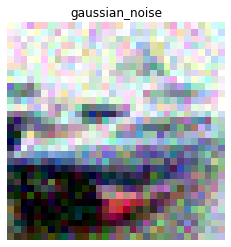

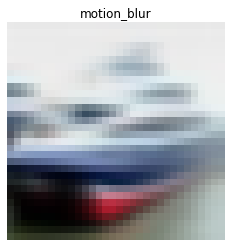

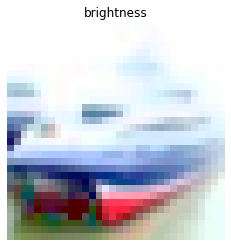

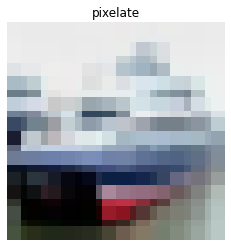

In [9]:
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

We can also verify that the performance of a classification model on CIFAR-10 drops significantly on this perturbed dataset:

In [10]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666


### Model distillation as a malicious drift detector

Analogously to the [adversarial AE detector](https://arxiv.org/abs/2002.09364), which uses an autoencoder to reproduce the output distribution of a classifier and produce adversarial scores, the model distillation detector achieves the same goal by using a simple classifier in place of the autoencoder. This approach is more flexible since it bypasses the instance's generation step, and it can be applied in a straightforward way to a variety of data sets such as text or time series.

We can use the adversarial scores produced by the Model Distillation detector in the context of drift detection. The score function of the detector becomes the preprocessing function for the drift detector. The K-S test is then a simple univariate test between the adversarial scores of the reference batch and the test data. Higher adversarial scores indicate more harmful drift. Importantly, a harmfulness detector flags **malicious data drift**. We can fetch the pretrained model distillation detector from a [Google Cloud Bucket](https://console.cloud.google.com/storage/browser/seldon-models/alibi-detect/ad/cifar10/resnet32/model_distillation/) or train one from scratch:

Definition and training of the distilled model

In [11]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from tensorflow.keras.regularizers import l1

def distilled_model_cifar10(clf, nb_conv_layers=3, nb_filters1=256, nb_dense=40,
                            kernel1=4, kernel2=4, kernel3=4, ae_arch=False):
    print('Define distilled model')
    nb_filters1 = int(nb_filters1)
    nb_filters2 = int(nb_filters1 / 2)
    nb_filters3 = int(nb_filters1 / 4)
    layers = [InputLayer(input_shape=(32, 32, 3)),
              Conv2D(nb_filters1, kernel1, strides=2, padding='same')]
    if nb_conv_layers > 1:
        layers.append(Conv2D(nb_filters2, kernel2, strides=2, padding='same',
                             activation=tf.nn.relu, kernel_regularizer=l1(1e-5)))
    if nb_conv_layers > 2:
        layers.append(Conv2D(nb_filters3, kernel3, strides=2, padding='same',
                             activation=tf.nn.relu, kernel_regularizer=l1(1e-5)))
    layers.append(Flatten())
    layers.append(Dense(nb_dense))
    layers.append(Dense(clf.output_shape[1], activation='softmax'))
    distilled_model = tf.keras.Sequential(layers)
    return distilled_model

In [12]:
def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return (y_true == y_pred).astype(int).sum() / y_true.shape[0]

In [13]:
load_pretrained = True

In [14]:
filepath = 'my_path' # change to (absolute) directory where model is downloaded
detector_type = 'adversarial'
detector_name = 'model_distillation'
filepath = os.path.join(filepath, detector_name)
if load_pretrained:
    ad = fetch_detector(filepath, detector_type, dataset, detector_name, model=model)
else:
    distilled_model = distilled_model_cifar10(clf)
    print(distilled_model.summary())
    ad = ModelDistillation(distilled_model=distilled_model, model=clf)
    ad.fit(X_train, epochs=50, batch_size=128, verbose=True)
    save_detector(ad, filepath)

No threshold level set. Need to infer threshold using `infer_threshold`.


#### Scores and p-values calculation

Here we initialize the K-S drift detector using the harmfulness scores as a preprocessing function. The KS test is performed on these scores.

In [15]:
batch_size = 100
nb_batches = 100
severities = [1, 2, 3, 4, 5]

In [16]:
def sample_batch(x_orig, x_corr, batch_size, p):
    nb_orig = int(batch_size * (1 - p))
    nb_corr = batch_size - nb_orig
    perc = np.round(nb_corr / batch_size, 2)
    
    idx_orig = np.random.choice(range(x_orig.shape[0]), nb_orig)
    x_sample_orig = x_orig[idx_orig]    
    
    idx_corr = np.random.choice(range(x_corr.shape[0]), nb_corr)
    x_sample_corr = x_corr[idx_corr]
    
    x_batch = np.concatenate([x_sample_orig, x_sample_corr])
    return x_batch, perc

Initialise the drift detector:

In [17]:
from functools import partial

np.random.seed(0)
n_ref = 1000
idx_ref = np.random.choice(range(X_test.shape[0]), n_ref)
X_test = scale_by_instance(X_test)
X_ref = X_test[idx_ref]
labels = ['No!', 'Yes!']

# adversarial score fn = preprocess step
preprocess_fn = partial(ad.score, batch_size=128)

# initialize the drift detector
cd = KSDrift(X_ref, p_val=.05, preprocess_fn=preprocess_fn)

Calculate scores. We split the corrupted data into harmful and harmless data and visualize the harmfulness scores for various values of corruption severity.

In [18]:
dfs = {}
score_drift = {
    1: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    2: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    3: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    4: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
    5: {'all': [], 'harm': [], 'noharm': [], 'acc': 0},
}
y_pred = predict_batch(X_test, clf, batch_size=256).argmax(axis=1)
score_x = ad.score(X_test, batch_size=256)

for s in severities:
    print('Loading corrupted data. Severity = {}'.format(s))
    X_corr, y_corr = fetch_cifar10c(corruption=corruptions, severity=s, return_X_y=True)
    print('Preprocess data...')
    X_corr = X_corr.astype('float32') / 255
    X_corr = scale_by_instance(X_corr)
    
    print('Make predictions on corrupted dataset...')
    y_pred_corr = predict_batch(X_corr, clf, batch_size=1000).argmax(axis=1)
    
    print('Compute adversarial scores on corrupted dataset...')
    score_corr = ad.score(X_corr, batch_size=256)
    
    labels_corr = np.zeros(score_corr.shape[0])
    repeat = y_corr.shape[0] // y_test.shape[0]
    y_pred_repeat = np.tile(y_pred, (repeat,))
    
    # malicious/harmful corruption: original prediction correct but
    # prediction on corrupted data incorrect
    idx_orig_right = np.where(y_pred_repeat == y_corr)[0]
    idx_corr_wrong = np.where(y_pred_corr != y_corr)[0]
    idx_harmful = np.intersect1d(idx_orig_right, idx_corr_wrong)
    
    # harmless corruption: original prediction correct and prediction
    # on corrupted data correct
    labels_corr[idx_harmful] = 1
    labels = np.concatenate([np.zeros(X_test.shape[0]), labels_corr]).astype(int)
    idx_corr_right = np.where(y_pred_corr == y_corr)[0]
    idx_harmless = np.intersect1d(idx_orig_right, idx_corr_right)
    
    # Split corrupted inputs in harmful and harmless
    X_corr_harm = X_corr[idx_harmful]
    X_corr_noharm = X_corr[idx_harmless]

    # Store adversarial scores for harmful and harmless data
    score_drift[s]['all'] = score_corr
    score_drift[s]['harm'] = score_corr[idx_harmful]
    score_drift[s]['noharm'] = score_corr[idx_harmless]
    score_drift[s]['acc'] = accuracy(y_corr, y_pred_corr)
    
    print('Compute p-values')
    for j in range(nb_batches):
        ps = []
        pvs_harm = []
        pvs_noharm = []
        for p in np.arange(0, 1, 0.1):
            # Sampling a batch of size `batch_size` where a fraction p of the data
            # is corrupted harmful data and a fraction 1 - p is non-corrupted data
            X_batch_harm, _ = sample_batch(X_test, X_corr_harm, batch_size, p)
            
            # Sampling a batch of size `batch_size` where a fraction p of the data
            # is corrupted harmless data and a fraction 1 - p is non-corrupted data
            X_batch_noharm, perc = sample_batch(X_test, X_corr_noharm, batch_size, p)
            
            # Calculating p-values for the harmful and harmless data by applying
            # K-S test on the adversarial scores
            pv_harm = cd.score(X_batch_harm)
            pv_noharm = cd.score(X_batch_noharm)
            ps.append(perc * 100)
            pvs_harm.append(pv_harm[0])
            pvs_noharm.append(pv_noharm[0])
        if j == 0:
            df = pd.DataFrame({'p': ps})
        df['pvalue_harm_{}'.format(j)] = pvs_harm
        df['pvalue_noharm_{}'.format(j)] = pvs_noharm 

    for name in ['pvalue_harm', 'pvalue_noharm']:
        df[name + '_mean'] = df[[col for col in df.columns if name in col]].mean(axis=1)
        df[name + '_std'] = df[[col for col in df.columns if name in col]].std(axis=1)
        df[name + '_max'] = df[[col for col in df.columns if name in col]].max(axis=1)
        df[name + '_min'] = df[[col for col in df.columns if name in col]].min(axis=1)
    df.set_index('p', inplace=True)
    dfs[s] = df

Loading corrupted data. Severity = 1
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 2
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 3
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 4
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values
Loading corrupted data. Severity = 5
Preprocess data...
Make predictions on corrupted dataset...
Compute adversarial scores on corrupted dataset...
Compute p-values


#### Plot scores

We now plot the mean scores and standard deviations per severity level. The plot shows the mean harmfulness scores (lhs) and ResNet-32 accuracies (rhs) for increasing data corruption severity levels. Level 0 corresponds to the original test set. Harmful scores  are scores from instances which have been flipped from the correct to an incorrect prediction because of the corruption. Not harmful means that a correct prediction was unchanged after the corruption.

In [19]:
mu_noharm, std_noharm = [], []
mu_harm, std_harm = [], []
acc = [clf_accuracy['original']]
for k, v in score_drift.items():
    mu_noharm.append(v['noharm'].mean())
    std_noharm.append(v['noharm'].std())
    mu_harm.append(v['harm'].mean())
    std_harm.append(v['harm'].std())
    acc.append(v['acc'])

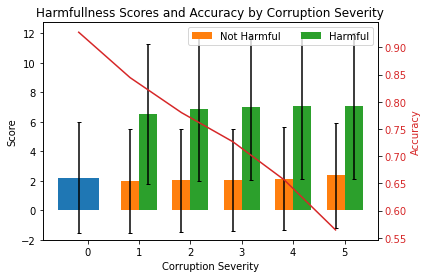

In [20]:
plot_labels = ['0', '1', '2', '3', '4', '5']

N = 6
ind = np.arange(N)
width = .35

fig_bar_cd, ax = plt.subplots()
ax2 = ax.twinx()

p0 = ax.bar(ind[0], score_x.mean(), yerr=score_x.std(), capsize=2)
p1 = ax.bar(ind[1:], mu_noharm, width, yerr=std_noharm, capsize=2)
p2 = ax.bar(ind[1:] + width, mu_harm, width, yerr=std_harm, capsize=2)

ax.set_title('Harmfullness Scores and Accuracy by Corruption Severity')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(plot_labels)
ax.set_ylim((-2))
ax.legend((p1[0], p2[0]), ('Not Harmful', 'Harmful'), loc='upper right', ncol=2)
ax.set_ylabel('Score')
ax.set_xlabel('Corruption Severity')

color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.show()

#### Plot p-values for contaminated batches

In order to simulate a realistic scenario, we perform a K-S test on batches of instance which are increasingly contaminated with corrupted data. The following steps are implemented:

* We randomly pick `n_ref=1000` samples from the non-currupted test set to be used as a reference set in the initialization of the K-S drift detector.  

* We sample batches of data of size `batch_size=100` contaminated with an increasing number of harmful corrupted data and harmless corrupted data. 

* The K-S detector predicts whether drift occurs between the contaminated batches and the reference data and returns the p-values of the test.

* We observe that contamination of the batches with harmful data reduces the p-values much faster than contamination with harmless data. In the latter case, the p-values remain above the detection threshold even when the batch is heavily contaminated

We repeat the test for 100 randomly sampled batches and we plot the mean and the maximum p-values for each level of severity and contamination below. We can see from the plot that the detector is able to clearly detect a batch contaminated with harmful data compared to a batch contaminated with harmless data when the percentage of currupted data reaches 20%-30%.  

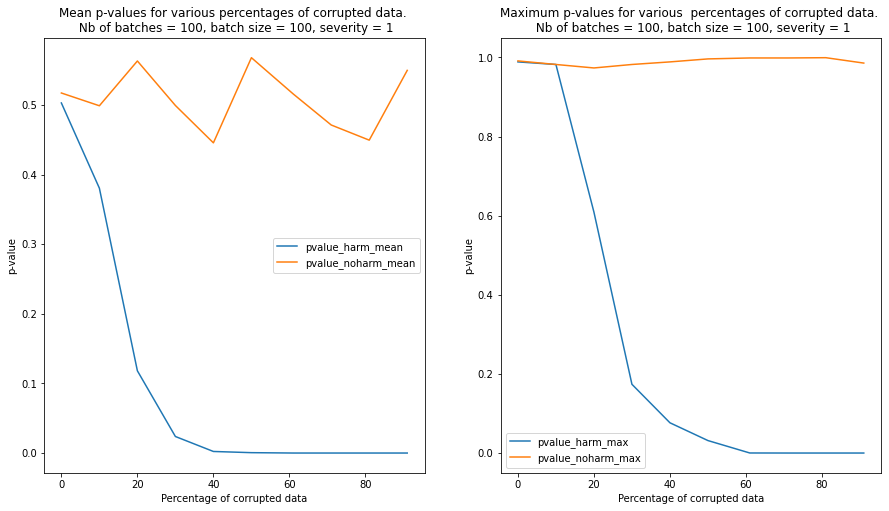

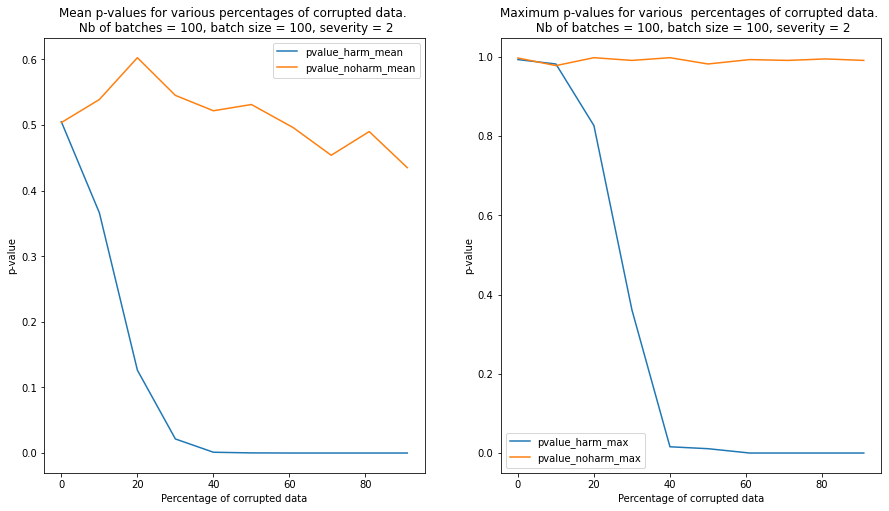

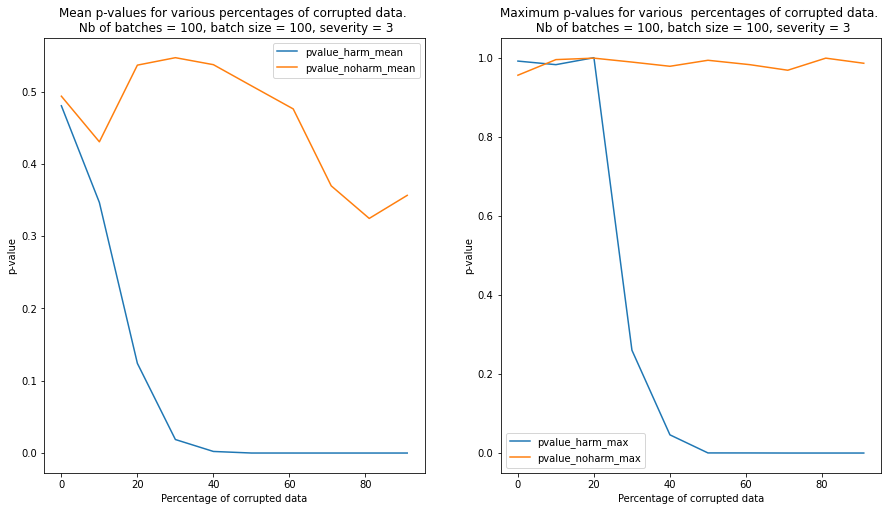

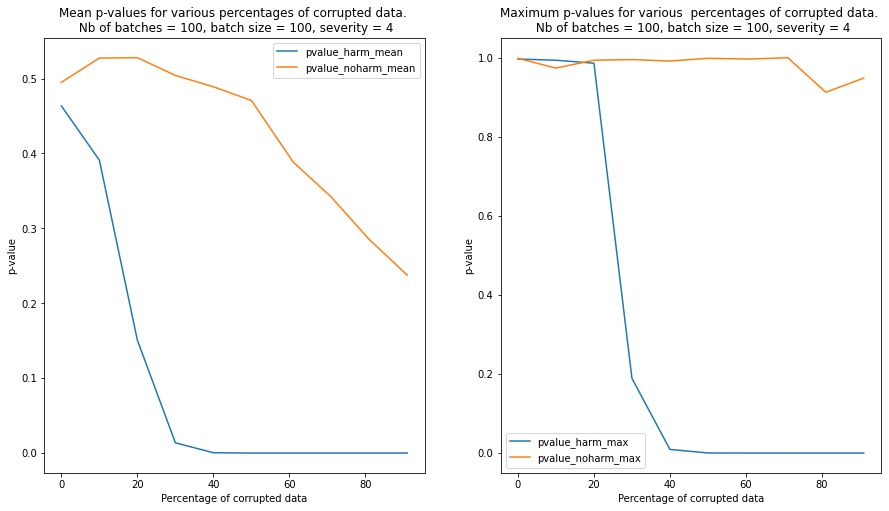

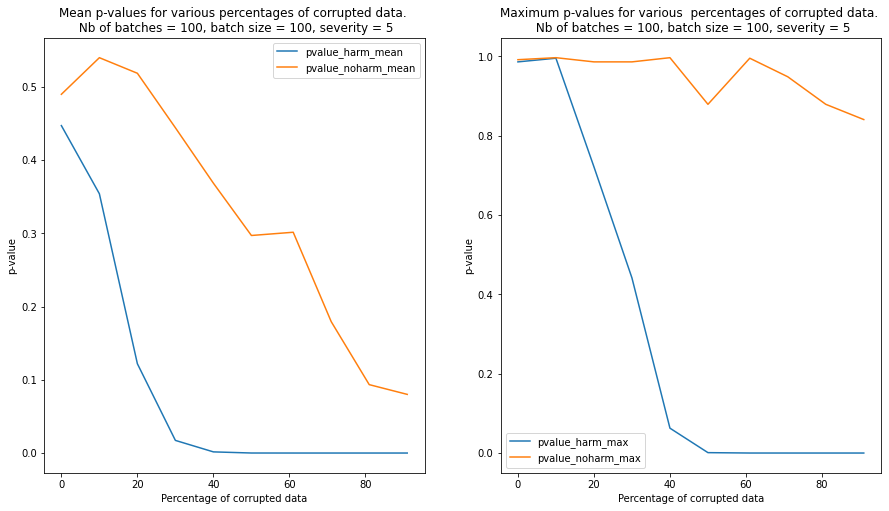

In [21]:
for s in severities:
    nrows = 1
    ncols = 2
    figsize = (15, 8)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    title0 = ('Mean p-values for various percentages of corrupted data. \n' 
             ' Nb of batches = {}, batch size = {}, severity = {}'.format(
                 nb_batches, batch_size, s))
    title1 = ('Maximum p-values for various  percentages of corrupted data. \n' 
             ' Nb of batches = {}, batch size = {}, severity = {}'.format(
                 nb_batches, batch_size, s))
    dfs[s][['pvalue_harm_mean', 'pvalue_noharm_mean']].plot(ax=ax[0], title=title0)
    dfs[s][['pvalue_harm_max', 'pvalue_noharm_max']].plot(ax=ax[1], title=title1)
    for a in ax:
        a.set_xlabel('Percentage of corrupted data')
        a.set_ylabel('p-value')